<a href="https://colab.research.google.com/github/gegretel/AML/blob/master/wine-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 # Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
import pandas as pd

def fetch_Wine_data():
    return pd.read_csv("https://raw.githubusercontent.com/gegretel/AML/master/wine.csv")

In [0]:
wine_data = fetch_Wine_data()
wine_data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Saving figure attribute_histogram_plots


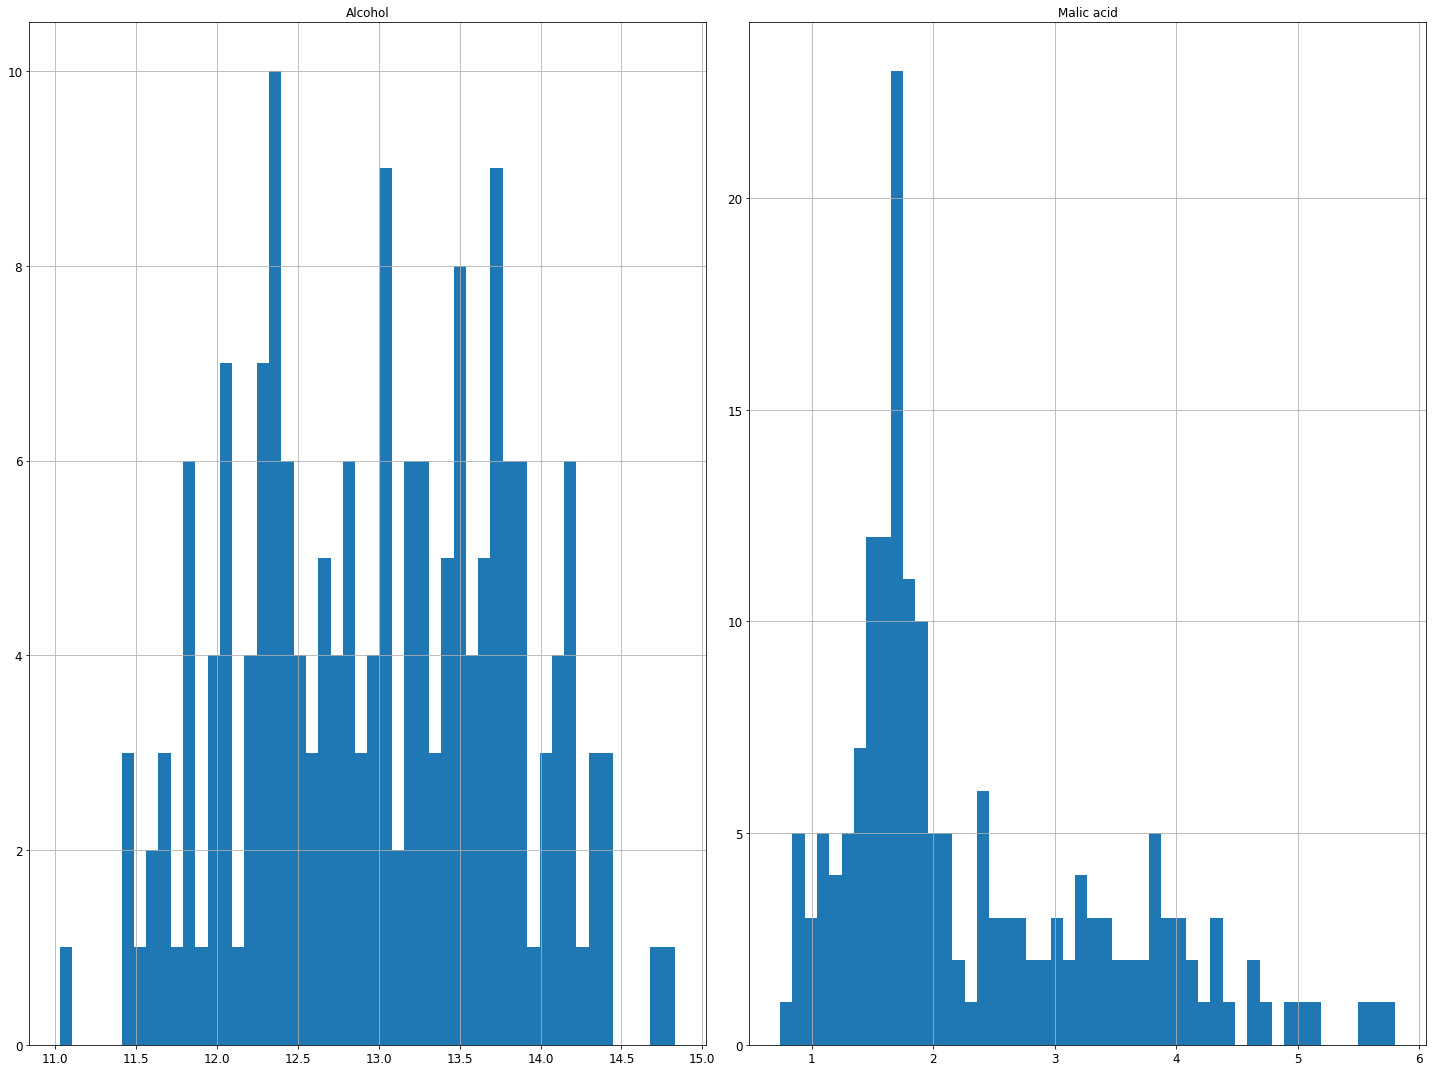

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
wine_data.hist(bins=50, figsize=(20,15), column=['Alcohol', 'Malic acid'])
save_fig("attribute_histogram_plots")
plt.show()

In [0]:
wine_data.corr()["Class"].sort_values(ascending = False)

Class                           1.000000
Alcalinity of ash               0.517859
Nonflavanoid phenols            0.489109
Malic acid                      0.437776
Color intensity                 0.265668
Ash                            -0.049643
Magnesium                      -0.209179
Alcohol                        -0.328222
Proanthocyanins                -0.499130
Hue                            -0.617369
Proline                        -0.633717
Total phenols                  -0.719163
OD280/OD315 of diluted wines   -0.788230
Flavanoids                     -0.847498
Name: Class, dtype: float64

In [0]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [0]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [0]:
train_set, test_set = split_train_test(wine_data, 0.2)
len(train_set)

143

In [0]:
len(test_set)

35

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [0]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [0]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [0]:
wine_with_id = wine_data.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(wine_with_id, 0.2, "index")

In [0]:
test_set.head()

,index,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
4,4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
11,11,1,14.12,1.48,2.32,16.8,95,2.20,2.43,0.26,1.57,5.00,1.17,2.82,1280
20,20,1,14.06,1.63,2.28,16.0,126,3.00,3.17,0.24,2.10,5.65,1.09,3.71,780
23,23,1,12.85,1.60,2.52,17.8,95,2.48,2.37,0.26,1.46,3.93,1.09,3.63,1015


In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(wine_data, test_size=0.2, random_state=42)

In [0]:
test_set.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
19,1,13.64,3.10,2.56,15.2,116,2.70,3.03,0.17,1.66,5.10,0.96,3.36,845
45,1,14.21,4.04,2.44,18.9,111,2.85,2.65,0.30,1.25,5.24,0.87,3.33,1080
140,3,12.93,2.81,2.70,21.0,96,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600
30,1,13.73,1.50,2.70,22.5,101,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285
67,2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510


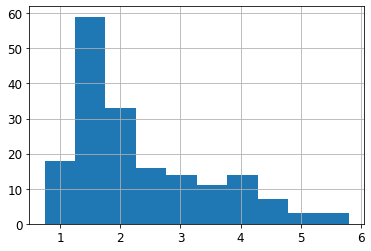

In [0]:
wine_data["Malic acid"].hist()

In [0]:
wine_data["acid_cat"] = pd.cut(wine_data["Malic acid"],
                               bins=[0., 1.0, 2.0, 3.0, 4.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [0]:
wine_data["acid_cat"].value_counts()

2    92
3    31
4    30
5    17
1     8
Name: acid_cat, dtype: int64

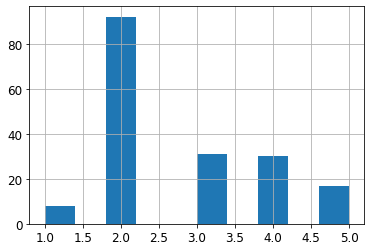

In [0]:
wine_data["acid_cat"].hist()

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(wine_data, wine_data["acid_cat"]):
    strat_train_set = wine_data.loc[train_index]
    strat_test_set = wine_data.loc[test_index]

In [0]:
strat_test_set["acid_cat"].value_counts() / len(strat_test_set)

2    0.527778
4    0.166667
3    0.166667
5    0.083333
1    0.055556
Name: acid_cat, dtype: float64

In [0]:
wine_data["acid_cat"].value_counts() / len(wine_data)

2    0.516854
3    0.174157
4    0.168539
5    0.095506
1    0.044944
Name: acid_cat, dtype: float64

In [0]:
def acid_cat_proportions(data):
    return data["acid_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(wine_data, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": acid_cat_proportions(wine_data),
    "Stratified": acid_cat_proportions(strat_test_set),
    "Random": acid_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [0]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.044944,0.055556,0.027778,-38.194444,23.611111
2,0.516854,0.527778,0.583333,12.862319,2.113527
3,0.174157,0.166667,0.138889,-20.250896,-4.301075
4,0.168539,0.166667,0.194444,15.370370,-1.111111
5,0.095506,0.083333,0.055556,-41.830065,-12.745098


In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("acid_cat", axis=1, inplace=True)